# Nov 23, 2025: align modes
agglomerative hierarchical clustering

hungarian + statistical testing for missing modes

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import re
from scipy import stats
from scipy.spatial.distance import jensenshannon, squareform, pdist, cdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr, gaussian_kde, ranksums, wilcoxon

from typing import Tuple

import glob
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'l1o'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

load membership matrices

In [10]:
boot_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
boots_df = []
for file in tqdm(boot_files):
    with open(file, 'rb') as f:
        df = pickle.load(f)
    boots_df += [df]

100%|██████████| 8/8 [00:00<00:00, 477.30it/s]


In [11]:
pis_df = pd.concat(boots_df).reset_index(drop=True)
# pis_df

In [12]:
def make_same_shape(Ms: list):
    num_rois = Ms[0].shape[0]
    num_comms = [M.shape[-1] for M in Ms]
    max_comms = np.max(num_comms)
    Rs = np.zeros((len(Ms), num_rois, max_comms))
    for idx, M in enumerate(Ms):
        Rs[idx, :, :M.shape[-1]] = M
    Rs = [Rs[idx, :, :] for idx in range(Rs.shape[0])]
    return Rs

In [13]:
cols = [c for c in pis_df.columns if 'pi' in c]

In [14]:
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols].apply(lambda pis: make_same_shape(pis.to_list())),
    ],
    axis=1
)

In [15]:
pis_df

sub       sbm     omega  \
0   sub-SLC01_task-rest  sbm-nd-h  0.239667   
1   sub-SLC01_task-rest  sbm-nd-h  0.178960   
2   sub-SLC01_task-rest  sbm-nd-h  0.148720   
3   sub-SLC01_task-rest  sbm-nd-h  0.136627   
4   sub-SLC01_task-rest  sbm-nd-h  0.101653   
..                  ...       ...       ...   
75  sub-SLC10_task-rest  sbm-nd-h  0.061306   
76  sub-SLC10_task-rest  sbm-nd-h  0.059932   
77  sub-SLC10_task-rest  sbm-nd-h  0.032006   
78  sub-SLC10_task-rest  sbm-nd-h  0.028166   
79  sub-SLC10_task-rest  sbm-nd-h  0.024205   

                                         pi_0_aligned  \
0   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
..                                                ...   
75  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
76  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
77  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
78  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
79  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         pi_1_aligned  \
0   [[0.9583333333333334, 0.0, 0.0, 0.0, 0.0416666...   
1   [[0.0223463687150838, 0.9162011173184358, 0.05...   
2   [[0.9664429530201343, 0.0, 0.03355704697986577...   
3   [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4   [[0.9509803921568627, 0.0, 0.0196078431372549,...   
..                                                ...   
75  [[0.9016393442622951, 0.0, 0.08196721311475409...   
76  [[0.9666666666666667, 0.0, 0.01666666666666666...   
77  [[0.875, 0.0, 0.0625, 0.0, 0.0625, 0.0, 0.0, 0...   
78  [[0.28571428571428575, 0.07142857142857144, 0....   
79  [[0.7916666666666666, 0.0, 0.20833333333333334...   

                                         pi_2_aligned  \
0   [[0.8709122474747475, 0.09354482323232324, 0.0...   
1   [[0.5652909386814435, 0.01847604666633236, 0.0...   
2   [[0.5543821376441529, 0.05269058978351352, 0.3...   
3   [[0.9343065693430657, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4   [[0.7541836135899148, 0.23370262449665105, 0.0...   
..                                                ...   
75  [[0.8204301351559689, 0.1098431317128321, 0.03...   
76  [[0.6323976608187134, 0.28149122807017546, 0.0...   
77  [[0.6015625, 0.15299479166666666, 0.1953125, 0...   
78  [[0.7811904761904763, 0.14568027210884354, 0.0...   
79  [[0.6414141414141414, 0.18860479797979798, 0.1...   

                                         pi_3_aligned  \
0   [[0.9524797771786139, 0.00806420889933821, 0.0...   
1   [[0.9773296277435477, 0.0011869306971700997, 0...   
2   [[0.954141671209906, 0.005269058978351351, 0.0...   
3   [[0.9863604880387874, 0.0, 0.0, 0.013639511961...   
4   [[0.9274761904619443, 0.01987402579111223, 0.0...   
..                                                ...   
75  [[0.9537120619695177, 0.005230625319658672, 0....   
76  [[0.9638278102664067, 0.010425601039636127, 0....   
77  [[0.9298502604166666, 0.0, 0.03255208333333333...   
78  [[0.9254271708683476, 0.008569427771108444, 0....   
79  [[0.9681202044483295, 0.023575599747474744, 0....   

                                         pi_4_aligned  \
0   [[0.9960191985676776, 0.00035200040117779746, ...   
1   [[0.9964514458035663, 3.201939677992657e-05, 0...   
2   [[0.9950968546583611, 0.004903145341639104, 0....   
3   [[1.0, 0.0, 0.0, 0.0], [0.9999650105803233, 3....   
4   [[0.9926060430040203, 0.0, 0.00739395699597955...   
..                                                ...   
75  [[0.9973846873401705, 0.0, 0.0, 0.002615312659...   
76  [[0.9988333333333332, 0.0011666666666666665, 0...   
77  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
78  [[1.0000000000000002, 0.0, 0.0, 0.0], [1.00000...   
79  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   

                              

In [16]:
def keep_select_comms(args: ARGS, Ms: list):
    Ms = np.stack(Ms)
    Ms = Ms[:, :, args.select_comms]
    return [Ms[i, :, :] for i in range(Ms.shape[0])]

In [17]:
if args.sbm in ['h']:
    args.select_comms = np.arange(0, 9) # for pi_1_aligned only
    args.num_comms = len(args.select_comms)
    i = 1
    cols1 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) < i]
    cols2 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) > i]
    pis_df = pd.concat(
        [
            pis_df[['sub', 'sbm', 'omega']],
            pis_df[cols1],
            pis_df[cols[i:i+1]].apply(lambda pis: keep_select_comms(args, pis.to_list())),
            pis_df[cols2],
        ],
        axis=1
    )
else:
    args.select_comms = np.arange(0, 9)
    args.num_comms = len(args.select_comms)
    pis_df = pd.concat(
        [
            pis_df[['sub', 'sbm', 'omega']],
            pis_df[cols].apply(lambda pis: keep_select_comms(args, pis.to_list())),
        ],
        axis=1,
    )

In [18]:
pis_df

sub       sbm     omega  \
0   sub-SLC01_task-rest  sbm-nd-h  0.239667   
1   sub-SLC01_task-rest  sbm-nd-h  0.178960   
2   sub-SLC01_task-rest  sbm-nd-h  0.148720   
3   sub-SLC01_task-rest  sbm-nd-h  0.136627   
4   sub-SLC01_task-rest  sbm-nd-h  0.101653   
..                  ...       ...       ...   
75  sub-SLC10_task-rest  sbm-nd-h  0.061306   
76  sub-SLC10_task-rest  sbm-nd-h  0.059932   
77  sub-SLC10_task-rest  sbm-nd-h  0.032006   
78  sub-SLC10_task-rest  sbm-nd-h  0.028166   
79  sub-SLC10_task-rest  sbm-nd-h  0.024205   

                                         pi_0_aligned  \
0   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
..                                                ...   
75  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
76  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
77  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
78  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
79  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         pi_1_aligned  \
0   [[0.9583333333333334, 0.0, 0.0, 0.0, 0.0416666...   
1   [[0.0223463687150838, 0.9162011173184358, 0.05...   
2   [[0.9664429530201343, 0.0, 0.03355704697986577...   
3   [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
4   [[0.9509803921568627, 0.0, 0.0196078431372549,...   
..                                                ...   
75  [[0.9016393442622951, 0.0, 0.08196721311475409...   
76  [[0.9666666666666667, 0.0, 0.01666666666666666...   
77  [[0.875, 0.0, 0.0625, 0.0, 0.0625, 0.0, 0.0, 0...   
78  [[0.28571428571428575, 0.07142857142857144, 0....   
79  [[0.7916666666666666, 0.0, 0.20833333333333334...   

                                         pi_2_aligned  \
0   [[0.8709122474747475, 0.09354482323232324, 0.0...   
1   [[0.5652909386814435, 0.01847604666633236, 0.0...   
2   [[0.5543821376441529, 0.05269058978351352, 0.3...   
3   [[0.9343065693430657, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4   [[0.7541836135899148, 0.23370262449665105, 0.0...   
..                                                ...   
75  [[0.8204301351559689, 0.1098431317128321, 0.03...   
76  [[0.6323976608187134, 0.28149122807017546, 0.0...   
77  [[0.6015625, 0.15299479166666666, 0.1953125, 0...   
78  [[0.7811904761904763, 0.14568027210884354, 0.0...   
79  [[0.6414141414141414, 0.18860479797979798, 0.1...   

                                         pi_3_aligned  \
0   [[0.9524797771786139, 0.00806420889933821, 0.0...   
1   [[0.9773296277435477, 0.0011869306971700997, 0...   
2   [[0.954141671209906, 0.005269058978351351, 0.0...   
3   [[0.9863604880387874, 0.0, 0.0, 0.013639511961...   
4   [[0.9274761904619443, 0.01987402579111223, 0.0...   
..                                                ...   
75  [[0.9537120619695177, 0.005230625319658672, 0....   
76  [[0.9638278102664067, 0.010425601039636127, 0....   
77  [[0.9298502604166666, 0.0, 0.03255208333333333...   
78  [[0.9254271708683476, 0.008569427771108444, 0....   
79  [[0.9681202044483295, 0.023575599747474744, 0....   

                                         pi_4_aligned  \
0   [[0.9960191985676776, 0.00035200040117779746, ...   
1   [[0.9964514458035663, 3.201939677992657e-05, 0...   
2   [[0.9950968546583611, 0.004903145341639104, 0....   
3   [[1.0, 0.0, 0.0, 0.0], [0.9999650105803233, 3....   
4   [[0.9926060430040203, 0.0, 0.00739395699597955...   
..                                                ...   
75  [[0.9973846873401705, 0.0, 0.0, 0.002615312659...   
76  [[0.9988333333333332, 0.0011666666666666665, 0...   
77  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
78  [[1.0000000000000002, 0.0, 0.0, 0.0], [1.00000...   
79  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   

                              

In [19]:
if args.sbm in ['h']: 
    col = cols[1]
else:
    col = cols[0]
col

'pi_1_aligned'

In [20]:
level = col.replace('pi_', '').replace('_aligned', '')
level

'1'

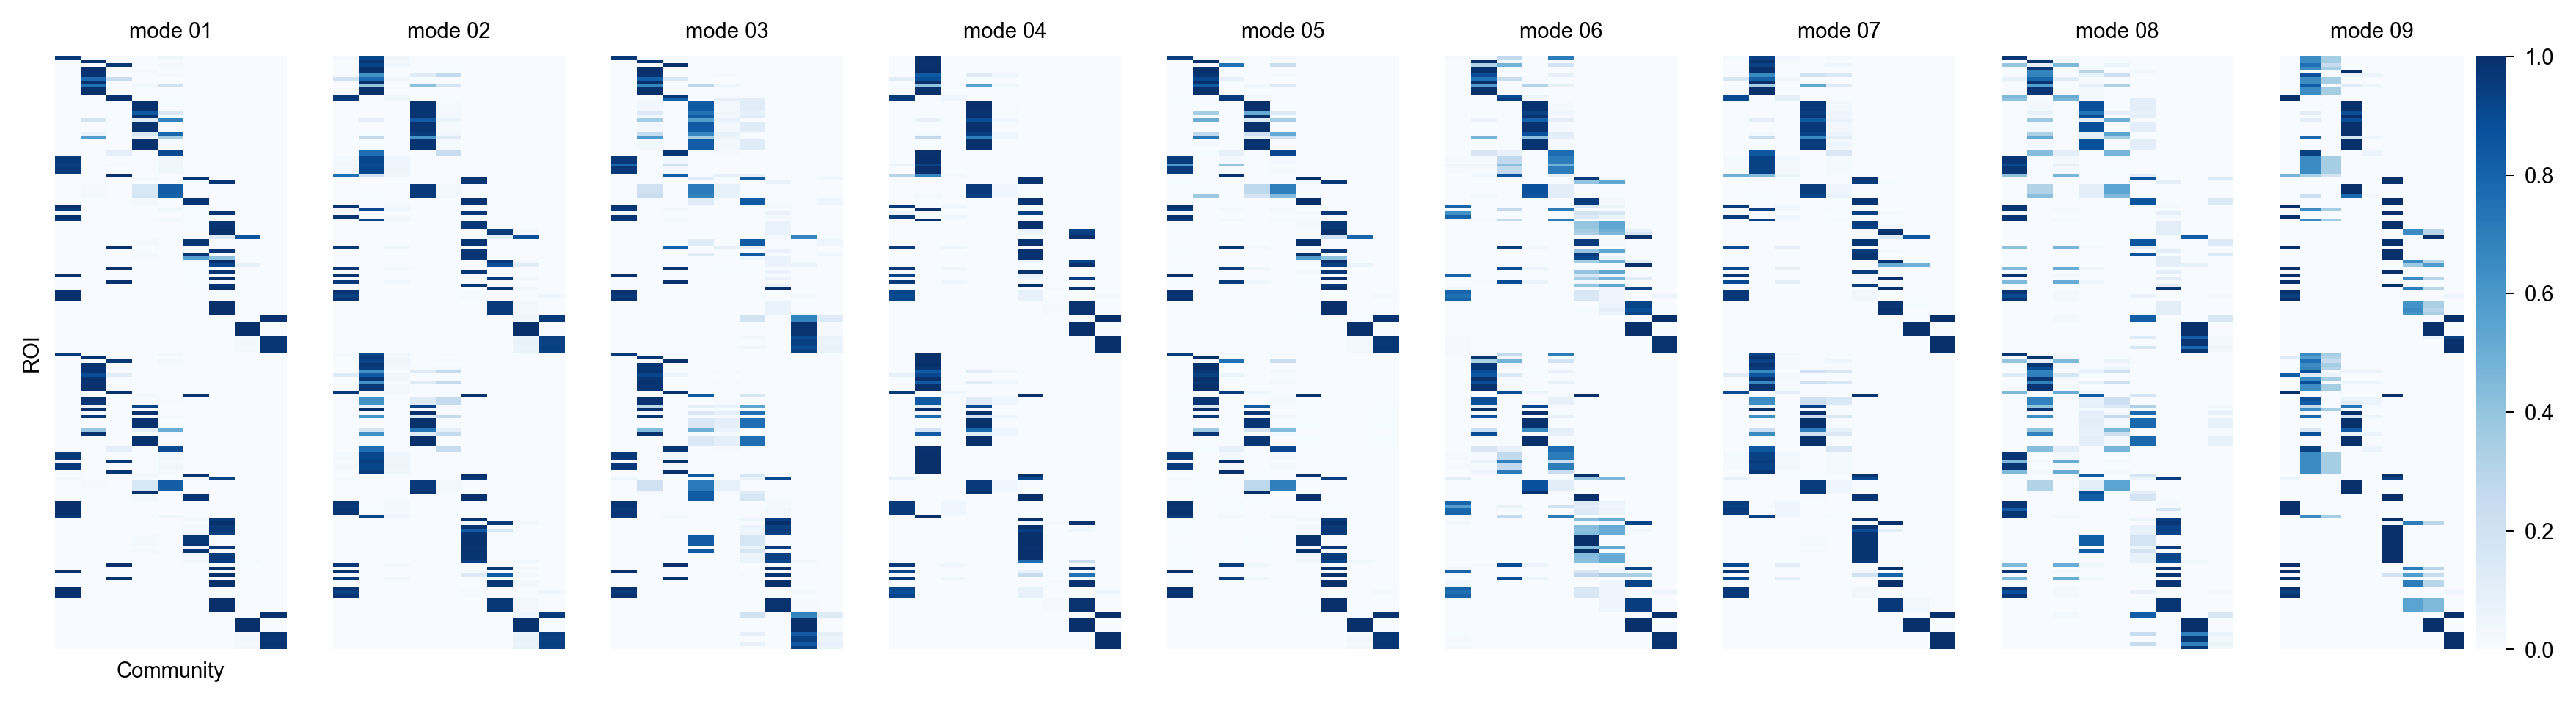

In [21]:
pis_ref = pis_df[pis_df['sub'].isin(['sub-SLC01_task-rest'])][col].to_list()
nrows = 1
ncols = len(pis_ref)
fig, axs = plt.subplots(nrows, ncols, figsize=(1.6*ncols, 3.5*nrows))
for idx_pi, pi in enumerate(pis_ref):
    ax = axs[idx_pi]
    sns.heatmap(pi, ax=ax, cbar=False if idx_pi < ncols-1 else True, cmap='Blues')
    ax.set(
        title=f'mode {idx_pi+1:02d}', 
        yticks=[], xticks=[],
        xlabel=f'Community' if idx_pi == 0 else '',
        ylabel=f'ROI' if idx_pi == 0 else '',
    )

In [22]:
pi.sum(axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.94117647, 0.94117647, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.94117647,
       0.96539792, 1.        , 1.        , 1.        , 0.94117647,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.94809689, 0.94809689, 0.94117647, 0.94809

In [23]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes.png', transparent=True, dpi=300, bbox_inches='tight')

center the matrices: remove the mean pi: work with residuals to amplify the differences: like data centering done before PCA or k-means clustering

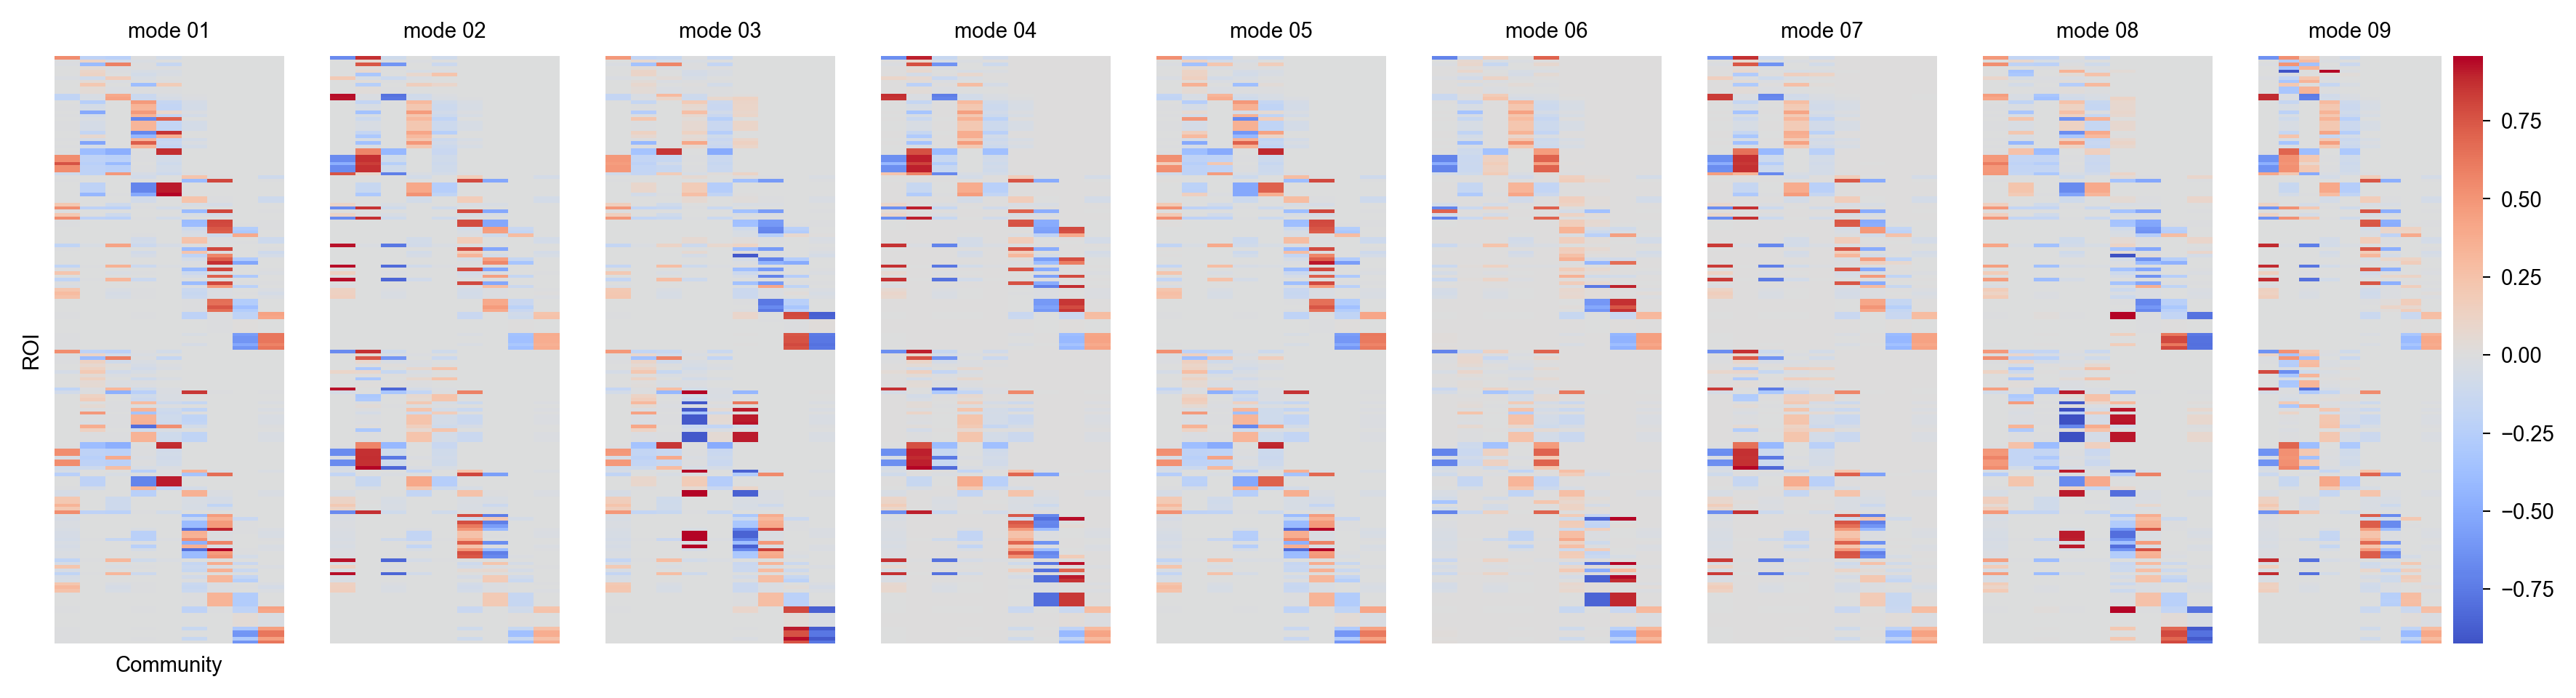

In [24]:
mean_pi = pis_df[col].mean()
pis_df[f'{col}_residual'] = pis_df[col].apply(lambda pi: pi - mean_pi)


pis_ref = pis_df[pis_df['sub'].isin(['sub-SLC01_task-rest'])][f'{col}_residual'].to_list()
nrows = 1
ncols = len(pis_ref)
fig, axs = plt.subplots(nrows, ncols, figsize=(1.6*ncols, 3.5*nrows))
for idx_pi, pi in enumerate(pis_ref):
    ax = axs[idx_pi]
    sns.heatmap(pi, ax=ax, cbar=False if idx_pi < ncols-1 else True, cmap='coolwarm', center=0)
    ax.set(
        title=f'mode {idx_pi+1:02d}', 
        yticks=[], xticks=[],
        xlabel=f'Community' if idx_pi == 0 else '',
        ylabel=f'ROI' if idx_pi == 0 else '',
    )

In [25]:
pis_df

sub       sbm     omega  \
0   sub-SLC01_task-rest  sbm-nd-h  0.239667   
1   sub-SLC01_task-rest  sbm-nd-h  0.178960   
2   sub-SLC01_task-rest  sbm-nd-h  0.148720   
3   sub-SLC01_task-rest  sbm-nd-h  0.136627   
4   sub-SLC01_task-rest  sbm-nd-h  0.101653   
..                  ...       ...       ...   
75  sub-SLC10_task-rest  sbm-nd-h  0.061306   
76  sub-SLC10_task-rest  sbm-nd-h  0.059932   
77  sub-SLC10_task-rest  sbm-nd-h  0.032006   
78  sub-SLC10_task-rest  sbm-nd-h  0.028166   
79  sub-SLC10_task-rest  sbm-nd-h  0.024205   

                                         pi_0_aligned  \
0   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4   [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
..                                                ...   
75  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
76  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
77  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
78  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
79  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         pi_1_aligned  \
0   [[0.9583333333333334, 0.0, 0.0, 0.0, 0.0416666...   
1   [[0.0223463687150838, 0.9162011173184358, 0.05...   
2   [[0.9664429530201343, 0.0, 0.03355704697986577...   
3   [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
4   [[0.9509803921568627, 0.0, 0.0196078431372549,...   
..                                                ...   
75  [[0.9016393442622951, 0.0, 0.08196721311475409...   
76  [[0.9666666666666667, 0.0, 0.01666666666666666...   
77  [[0.875, 0.0, 0.0625, 0.0, 0.0625, 0.0, 0.0, 0...   
78  [[0.28571428571428575, 0.07142857142857144, 0....   
79  [[0.7916666666666666, 0.0, 0.20833333333333334...   

                                         pi_2_aligned  \
0   [[0.8709122474747475, 0.09354482323232324, 0.0...   
1   [[0.5652909386814435, 0.01847604666633236, 0.0...   
2   [[0.5543821376441529, 0.05269058978351352, 0.3...   
3   [[0.9343065693430657, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4   [[0.7541836135899148, 0.23370262449665105, 0.0...   
..                                                ...   
75  [[0.8204301351559689, 0.1098431317128321, 0.03...   
76  [[0.6323976608187134, 0.28149122807017546, 0.0...   
77  [[0.6015625, 0.15299479166666666, 0.1953125, 0...   
78  [[0.7811904761904763, 0.14568027210884354, 0.0...   
79  [[0.6414141414141414, 0.18860479797979798, 0.1...   

                                         pi_3_aligned  \
0   [[0.9524797771786139, 0.00806420889933821, 0.0...   
1   [[0.9773296277435477, 0.0011869306971700997, 0...   
2   [[0.954141671209906, 0.005269058978351351, 0.0...   
3   [[0.9863604880387874, 0.0, 0.0, 0.013639511961...   
4   [[0.9274761904619443, 0.01987402579111223, 0.0...   
..                                                ...   
75  [[0.9537120619695177, 0.005230625319658672, 0....   
76  [[0.9638278102664067, 0.010425601039636127, 0....   
77  [[0.9298502604166666, 0.0, 0.03255208333333333...   
78  [[0.9254271708683476, 0.008569427771108444, 0....   
79  [[0.9681202044483295, 0.023575599747474744, 0....   

                                         pi_4_aligned  \
0   [[0.9960191985676776, 0.00035200040117779746, ...   
1   [[0.9964514458035663, 3.201939677992657e-05, 0...   
2   [[0.9950968546583611, 0.004903145341639104, 0....   
3   [[1.0, 0.0, 0.0, 0.0], [0.9999650105803233, 3....   
4   [[0.9926060430040203, 0.0, 0.00739395699597955...   
..                                                ...   
75  [[0.9973846873401705, 0.0, 0.0, 0.002615312659...   
76  [[0.9988333333333332, 0.0011666666666666665, 0...   
77  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
78  [[1.0000000000000002, 0.0, 0.0, 0.0], [1.00000...   
79  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   

                              

In [26]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes-centered.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes-centered.png', transparent=True, dpi=300, bbox_inches='tight')

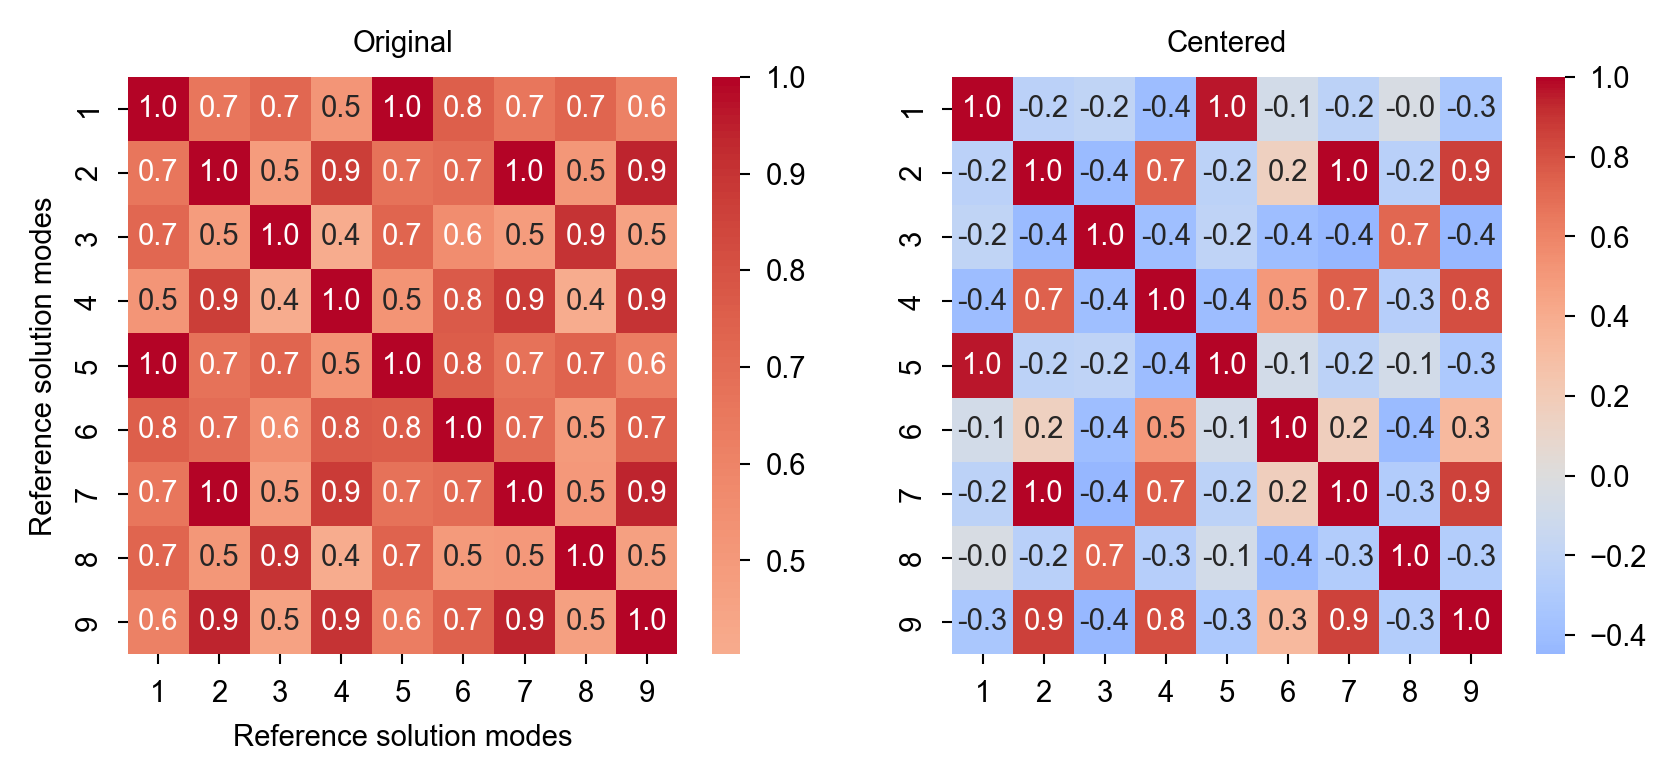

In [27]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(3.25*ncols, 2.5*nrows))

ax = axs[0]
X = np.stack(pis_df[pis_df['sub'].isin(['sub-SLC01_task-rest'])][col].apply(lambda pi: pi.flatten()).to_list())
corr_mat = np.corrcoef(X)
sns.heatmap(
    corr_mat, 
    ax=ax, 
    cmap='coolwarm', center=0,
    annot=True, fmt='.1f',
)
_ = ax.set(xticklabels=range(1, X.shape[0]+1), yticklabels=range(1, X.shape[0]+1), title=f'Original', ylabel=f'Reference solution modes', xlabel=f'Reference solution modes')

ax = axs[1]
X = np.stack(pis_df[pis_df['sub'].isin(['sub-SLC01_task-rest'])][f'{col}_residual'].apply(lambda pi: pi.flatten()).to_list())
corr_mat = np.corrcoef(X)
sns.heatmap(
    corr_mat, 
    ax=ax, 
    cmap='coolwarm', center=0,
    annot=True, fmt='.1f',
)
_ = ax.set(xticklabels=range(1, X.shape[0]+1), yticklabels=range(1, X.shape[0]+1), title=f'Centered')

In [28]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes-correlations.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes-correlations.png', transparent=True, dpi=300, bbox_inches='tight')

merge redundant modes

In [29]:
def tvd(pia, pib):
    diff = np.abs(pia - pib)
    row_sum = np.sum(diff, axis=1)
    return 0.5 * np.mean(row_sum)

def pearson_dist(pia, pib):
    r, _ = pearsonr(pia.flatten(), pib.flatten())
    return 1 - r # in the range [0, 2]

def get_dist_mat(mode_list, dist_func=pearson_dist):
    dist_mat = np.zeros((len(mode_list), len(mode_list)))
    for i in range(len(mode_list)):
        for j in range(i+1, len(mode_list)):
            pia = mode_list[i]
            pib = mode_list[j]
            dist_mat[i, j] = dist_func(pia, pib)
            dist_mat[j, i] = dist_mat[i, j]
    return dist_mat

In [30]:
def cluster_and_merge_modes(df: pd.DataFrame, col: str):
    mode_list = df[col].to_list()
    omegas = df['omega'].to_list()
    
    n = len(mode_list)
    if n <= 2: 
        sil_df = pd.DataFrame(dict(
            k=[n],
            labels=[np.arange(1, n+1)],
            score=[1],
        ))
        return sil_df, mode_list, omegas
        
    
    dist_mat = get_dist_mat(mode_list)
    
    dist_vec = squareform(dist_mat, checks=False)
    
    Z = linkage(dist_vec, method='average')
    
    sil_df = []
    for k in range(2, n):
        labels = fcluster(Z, t=k, criterion='maxclust')
        score = silhouette_score(dist_mat, labels, metric='precomputed') 
        row = pd.DataFrame(dict(
            k=[k],
            labels=[labels],
            score=[score],
        ))
        sil_df += [row]
    sil_df = pd.concat(sil_df).reset_index(drop=True)
    
    best_score = np.argmax(sil_df['score'])
    best_labels = sil_df['labels'][best_score]
    
    merged_modes = []
    unique_labels = np.unique(best_labels)
    for lbl in unique_labels:
        idxs = np.where(best_labels == lbl)[0]
        cluster_pis = [mode_list[i] for i in idxs]
        mean_pi = np.mean(cluster_pis, axis=0)
        # rsum = mean_pi.sum(axis=1)[:, np.newaxis]
        # mean_pi = np.nan_to_num(mean_pi / rsum)
        merged_modes.append(mean_pi)
    
    merged_omegas = np.bincount(best_labels, omegas)[1:] # ignore the 0th count, which is anyways 0
    return sil_df, merged_modes, merged_omegas

In [31]:
if args.sbm in ['h']:
    col = f'{cols[1]}_residual'
else:
    col = f'{cols[0]}_residual'
col

'pi_1_aligned_residual'

In [32]:
merged_pis_df = []
for [sub], group in pis_df.groupby(by=['sub']):
    sil_df, merged_modes, merged_omegas = cluster_and_merge_modes(group, col)
    
    row = pd.DataFrame(dict(
        sub=[group['sub'].to_list()[0]]*len(merged_omegas),
        sbm=[group['sbm'].to_list()[0]]*len(merged_omegas),
        omega=merged_omegas,
        pi=merged_modes,
        sil=[sil_df]*len(merged_omegas),
    ))
    row.sort_values(by='omega', ascending=False, inplace=True)
    merged_pis_df += [row]
merged_pis_df = pd.concat(merged_pis_df).reset_index(drop=True)
merged_pis_df

sub       sbm     omega  \
0   sub-SLC01_task-rest  sbm-nd-h  0.458960   
1   sub-SLC01_task-rest  sbm-nd-h  0.341320   
2   sub-SLC01_task-rest  sbm-nd-h  0.199720   
3   sub-SLC03_task-rest  sbm-nd-h  0.477551   
4   sub-SLC03_task-rest  sbm-nd-h  0.316327   
5   sub-SLC03_task-rest  sbm-nd-h  0.148566   
6   sub-SLC03_task-rest  sbm-nd-h  0.032440   
7   sub-SLC03_task-rest  sbm-nd-h  0.025117   
8   sub-SLC04_task-rest  sbm-nd-h  0.839240   
9   sub-SLC04_task-rest  sbm-nd-h  0.160760   
10  sub-SLC05_task-rest  sbm-nd-h  0.502432   
11  sub-SLC05_task-rest  sbm-nd-h  0.349257   
12  sub-SLC05_task-rest  sbm-nd-h  0.148311   
13  sub-SLC06_task-rest  sbm-nd-h  0.286409   
14  sub-SLC06_task-rest  sbm-nd-h  0.249777   
15  sub-SLC06_task-rest  sbm-nd-h  0.238472   
16  sub-SLC06_task-rest  sbm-nd-h  0.070573   
17  sub-SLC06_task-rest  sbm-nd-h  0.068400   
18  sub-SLC06_task-rest  sbm-nd-h  0.063401   
19  sub-SLC06_task-rest  sbm-nd-h  0.022969   
20  sub-SLC07_task-rest  sbm-nd-h  0.637920   
21  sub-SLC07_task-rest  sbm-nd-h  0.362080   
22  sub-SLC09_task-rest  sbm-nd-h  0.429741   
23  sub-SLC09_task-rest  sbm-nd-h  0.280904   
24  sub-SLC09_task-rest  sbm-nd-h  0.150143   
25  sub-SLC09_task-rest  sbm-nd-h  0.139212   
26  sub-SLC10_task-rest  sbm-nd-h  0.553364   
27  sub-SLC10_task-rest  sbm-nd-h  0.418470   
28  sub-SLC10_task-rest  sbm-nd-h  0.028166   

                                                   pi  \
0   [[-0.6203013659536094, 0.5780991368661561, 0.0...   
1   [[0.32353061144695866, -0.12451502028197585, -...   
2   [[0.3422913036433003, -0.12451502028197585, -0...   
3   [[-0.610364838624962, -0.1117268212460163, 0.7...   
4   [[0.30228148679709876, -0.12253089329784886, -...   
5   [[-0.32266278493993616, 0.05998469053352446, -...   
6   [[0.3063737487018606, -0.12451502028197585, -0...   
7   [[-0.07112625129813932, -0.08451502028197586, ...   
8   [[0.1948580176645093, -0.12231721808417363, -0...   
9   [[0.19723911979616, -0.12451502028197585, 0.00...   
10  [[0.24681956389295884, -0.12195091771787328, -...   
11  [[0.3250425798706918, -0.12054676631372188, -0...   
12  [[-0.512468478910834, 0.20598831507278462, 0.1...   
13  [[-0.6234730535459316, 0.7926377760787413, -0....   
14  [[0.17384773677444026, -0.02992042568738125, -...   
15  [[-0.5972689171998414, 0.7831346259218872, -0....   
16  [[-0.6311262512981394, -0.12451502028197585, -...   
17  [[-0.601714486592257, -0.12451502028197585, 0....   
18  [[0.14665152647963842, -0.12451502028197585, 0...   
19  [[-0.6311262512981394, -0.03755849854284542, -...   
20  [[0.3594800408316175, -0.12451502028197585, -0...   
21  [[0.3424103849748586, -0.12451502028197585, -0...   
22  [[0.3091443750779637, -0.12451502028197585, -0...   
23  [[-0.5072812438465746, -0.12451502028197585, -...   
24  [[0.2886818475797269, -0.10633320210015768, -0...   
25  [[-0.3925578752297633, -0.017997926264881826, ...   
26  [[0.3000324874054252, -0.12451502028197584, -0...   
27  [[0.3255684655078481, -0.12451502028197585, -0...   
28  [[-0.3454119655838536, -0.05308644885340441, 0...   

                                                  sil  
0      k                       labels     score
0 ...  
1      k                       labels     score
0 ...  
2      k                       labels     score
0 ...  
3      k                          labels     score...  
4      k                          labels     score...  
5      k                          labels     score...  
6      k                          labels     score...  
7      k                          labels     score...  
8      k                       labels     score
0 ...  
9      k                       labels     score
0 ...  
10      k                              labels     ...  
11      k                              labels     ...  
12      k                              labels     ...  
13      k                              labels     ...  
14      k                              labels     ...  
15

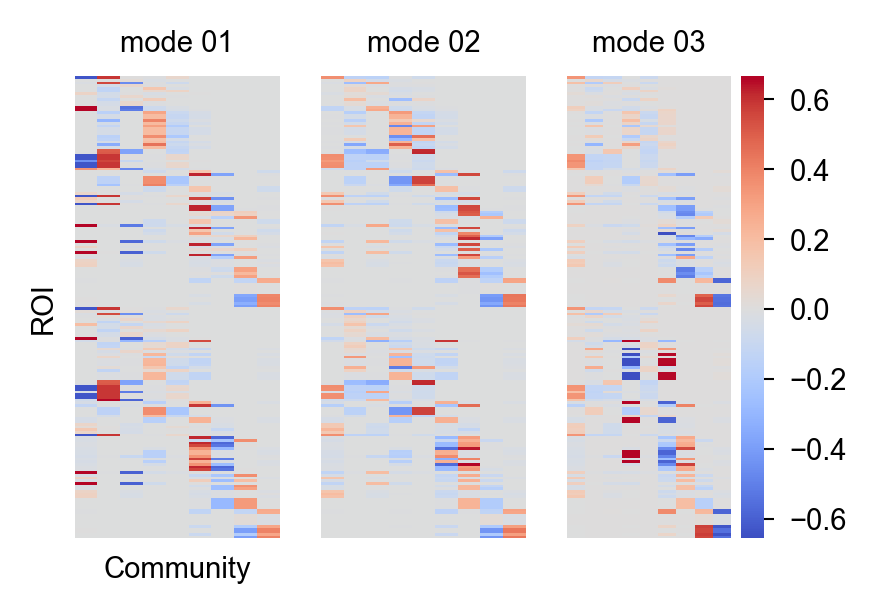

In [33]:
group = merged_pis_df[merged_pis_df['sub'].isin(['sub-SLC01_task-rest'])]
merged_modes = group['pi'].to_list() #+ mean_pi
merged_omegas = group['omega'].to_list()
sil_df = group['sil'].to_list()[0]

nrows = 1
ncols = len(merged_modes)
fig, axs = plt.subplots(nrows, ncols, figsize=(1*ncols, 2*nrows))
for idx_pi, pi in enumerate(merged_modes):
    ax = axs[idx_pi] if ncols > 1 else axs
    sns.heatmap(pi, ax=ax, cbar=False if idx_pi < ncols-1 else True, cmap='coolwarm', center=0)
    ax.set(
        title=f'mode {idx_pi+1:02d}', 
        xticks=[], yticks=[], 
        # xlabel=r'$\omega_{k}$' + f' {merged_omegas[idx_pi]:.2f}'
        xlabel=f'Community' if idx_pi == 0 else '',
        ylabel=f'ROI' if idx_pi == 0 else '',
    )

In [34]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-super-modes-centered.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-super-modes-centered.png', transparent=True, dpi=300, bbox_inches='tight')

In [35]:
def get_corr_matrix(pis_ref, pis_sample):
    n_ref = len(pis_ref)
    n_boot = len(pis_sample)

    corr_matrix = np.zeros((n_ref, n_boot))

    for i in range(n_ref):
        for j in range(n_boot):
            # Flatten matrices to 1D vectors for correlation
            # This captures the "Global Spatial Similarity"
            r, _ = pearsonr(pis_ref[i].flatten(), pis_sample[j].flatten())
            corr_matrix[i, j] = r
    return corr_matrix

[Text(0.5, 41.3333333333333, 'Reference super-modes'),
 Text(5.333333333333332, 0.5, 'Reference super-modes'),
 Text(0.5, 1.0, 'Pearson correlation')]

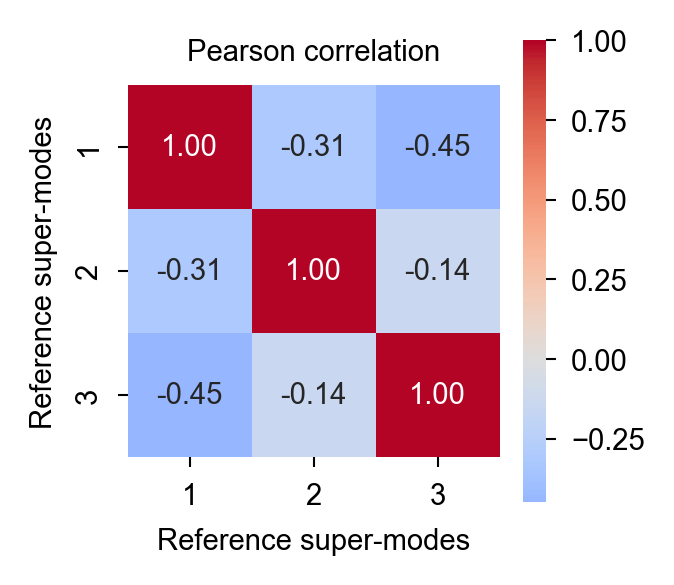

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
sns.heatmap(
    get_corr_matrix(merged_modes, merged_modes), 
    ax=ax, 
    cmap='coolwarm',
    square=True,
    annot=True,
    fmt='.2f',
    center=0,
)
ax.set(xticklabels=range(1, len(group)+1), yticklabels=range(1, len(group)+1))
ax.set(xlabel='Reference super-modes', ylabel='Reference super-modes', title=f'Pearson correlation')

In [37]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-super-modes-correlations.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-super-modes-correlations.png', transparent=True, dpi=300, bbox_inches='tight')

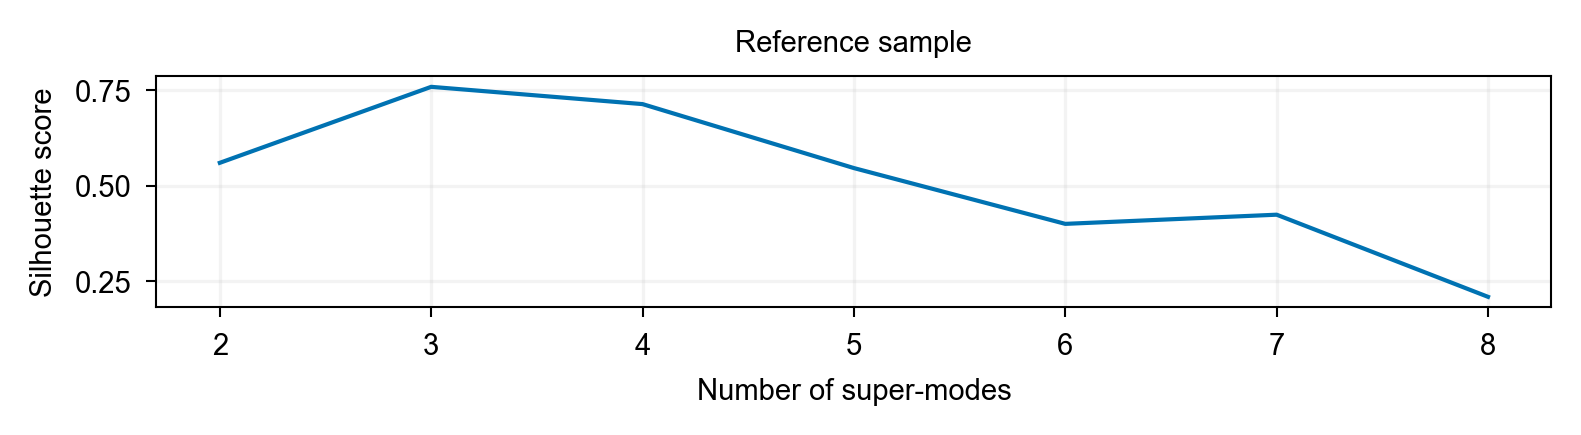

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1))
ax.plot(sil_df['k'], sil_df['score'])
ax.set(xticks=sil_df['k'], xlabel=f'Number of super-modes', ylabel=f'Silhouette score', title=f'Reference sample')
ax.grid(alpha=0.15)

In [39]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-silhouette-scores.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-silhouette-scores.png', transparent=True, dpi=300, bbox_inches='tight')

In [40]:
merged_pis_df_ = merged_pis_df.copy(deep=True)
merged_pis_df_['pi'] = merged_pis_df_['pi'].apply(lambda pi: pi + mean_pi)
merged_pis_df_['pi']

0     [[0.010824885344529966, 0.7026141571481319, 0....
1     [[0.954656862745098, 0.0, 0.009803921568627444...
2     [[0.9734175549414397, 0.0, 0.02658244505856033...
3     [[0.020761412673177326, 0.012788199035959555, ...
4     [[0.9334077380952381, 0.001984126984126991, 0....
5     [[0.3084634663582032, 0.18449971081550032, 0.1...
6     [[0.9375, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0...
7     [[0.56, 0.039999999999999994, 0.4, 0.0, 0.0, 0...
8     [[0.8259842689626486, 0.0021978021978022177, 0...
9     [[0.8283653710942993, 0.0, 0.1476361897797902,...
10    [[0.8779458151910982, 0.002564102564102569, 0....
11    [[0.9561688311688312, 0.003968253968253968, 0....
12    [[0.11865777238730535, 0.33050333535476045, 0....
13    [[0.007653197752207741, 0.9171527963607171, 0....
14    [[0.8049739880725797, 0.0945945945945946, 0.04...
15    [[0.03385733409829794, 0.907649646203863, 0.05...
16    [[0.0, 0.0, 0.028169014084507046, 0.0, 0.97183...
17    [[0.02941176470588236, 0.0, 0.691176470588

In [41]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/method-hierarchical_desc-merged-pis.pkl', 'wb') as f:
    pickle.dump(merged_pis_df_, f)

align

Hungarian, or Linear Sum Assignment

In [42]:
col = 'pi'
# col = cols[1]
# merged_pis_df = pis_df

In [43]:
merged_pis_df

sub       sbm     omega  \
0   sub-SLC01_task-rest  sbm-nd-h  0.458960   
1   sub-SLC01_task-rest  sbm-nd-h  0.341320   
2   sub-SLC01_task-rest  sbm-nd-h  0.199720   
3   sub-SLC03_task-rest  sbm-nd-h  0.477551   
4   sub-SLC03_task-rest  sbm-nd-h  0.316327   
5   sub-SLC03_task-rest  sbm-nd-h  0.148566   
6   sub-SLC03_task-rest  sbm-nd-h  0.032440   
7   sub-SLC03_task-rest  sbm-nd-h  0.025117   
8   sub-SLC04_task-rest  sbm-nd-h  0.839240   
9   sub-SLC04_task-rest  sbm-nd-h  0.160760   
10  sub-SLC05_task-rest  sbm-nd-h  0.502432   
11  sub-SLC05_task-rest  sbm-nd-h  0.349257   
12  sub-SLC05_task-rest  sbm-nd-h  0.148311   
13  sub-SLC06_task-rest  sbm-nd-h  0.286409   
14  sub-SLC06_task-rest  sbm-nd-h  0.249777   
15  sub-SLC06_task-rest  sbm-nd-h  0.238472   
16  sub-SLC06_task-rest  sbm-nd-h  0.070573   
17  sub-SLC06_task-rest  sbm-nd-h  0.068400   
18  sub-SLC06_task-rest  sbm-nd-h  0.063401   
19  sub-SLC06_task-rest  sbm-nd-h  0.022969   
20  sub-SLC07_task-rest  sbm-nd-h  0.637920   
21  sub-SLC07_task-rest  sbm-nd-h  0.362080   
22  sub-SLC09_task-rest  sbm-nd-h  0.429741   
23  sub-SLC09_task-rest  sbm-nd-h  0.280904   
24  sub-SLC09_task-rest  sbm-nd-h  0.150143   
25  sub-SLC09_task-rest  sbm-nd-h  0.139212   
26  sub-SLC10_task-rest  sbm-nd-h  0.553364   
27  sub-SLC10_task-rest  sbm-nd-h  0.418470   
28  sub-SLC10_task-rest  sbm-nd-h  0.028166   

                                                   pi  \
0   [[-0.6203013659536094, 0.5780991368661561, 0.0...   
1   [[0.32353061144695866, -0.12451502028197585, -...   
2   [[0.3422913036433003, -0.12451502028197585, -0...   
3   [[-0.610364838624962, -0.1117268212460163, 0.7...   
4   [[0.30228148679709876, -0.12253089329784886, -...   
5   [[-0.32266278493993616, 0.05998469053352446, -...   
6   [[0.3063737487018606, -0.12451502028197585, -0...   
7   [[-0.07112625129813932, -0.08451502028197586, ...   
8   [[0.1948580176645093, -0.12231721808417363, -0...   
9   [[0.19723911979616, -0.12451502028197585, 0.00...   
10  [[0.24681956389295884, -0.12195091771787328, -...   
11  [[0.3250425798706918, -0.12054676631372188, -0...   
12  [[-0.512468478910834, 0.20598831507278462, 0.1...   
13  [[-0.6234730535459316, 0.7926377760787413, -0....   
14  [[0.17384773677444026, -0.02992042568738125, -...   
15  [[-0.5972689171998414, 0.7831346259218872, -0....   
16  [[-0.6311262512981394, -0.12451502028197585, -...   
17  [[-0.601714486592257, -0.12451502028197585, 0....   
18  [[0.14665152647963842, -0.12451502028197585, 0...   
19  [[-0.6311262512981394, -0.03755849854284542, -...   
20  [[0.3594800408316175, -0.12451502028197585, -0...   
21  [[0.3424103849748586, -0.12451502028197585, -0...   
22  [[0.3091443750779637, -0.12451502028197585, -0...   
23  [[-0.5072812438465746, -0.12451502028197585, -...   
24  [[0.2886818475797269, -0.10633320210015768, -0...   
25  [[-0.3925578752297633, -0.017997926264881826, ...   
26  [[0.3000324874054252, -0.12451502028197584, -0...   
27  [[0.3255684655078481, -0.12451502028197585, -0...   
28  [[-0.3454119655838536, -0.05308644885340441, 0...   

                                                  sil  
0      k                       labels     score
0 ...  
1      k                       labels     score
0 ...  
2      k                       labels     score
0 ...  
3      k                          labels     score...  
4      k                          labels     score...  
5      k                          labels     score...  
6      k                          labels     score...  
7      k                          labels     score...  
8      k                       labels     score
0 ...  
9      k                       labels     score
0 ...  
10      k                              labels     ...  
11      k                              labels     ...  
12      k                              labels     ...  
13      k                              labels     ...  
14      k                              labels     ...  
15

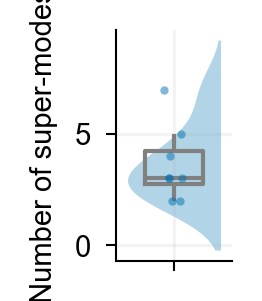

In [44]:
num_modes_all = []
for sub, group in merged_pis_df.groupby('sub'):
    num_modes_all+= [len(group)]

fig, ax = plt.subplots(1, 1, figsize=(0.5, 1))
sns.violinplot(
    data=num_modes_all, 
    ax=ax, 
    split=True,
    inner=None,
    density_norm='count',
    color=CUD_COLORS[0],
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)

sns.boxplot(
    data=num_modes_all, 
    ax=ax,
    color='grey',
    fill=False, 
    width=0.5, 
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=num_modes_all, 
    ax=ax,
    color=CUD_COLORS[0],
    size=2,
    marker='o',
    alpha=0.5, 
    jitter=True,
)

ax.set(
    title=f'',
    ylabel=f'Number of super-modes',
)
ax.grid(alpha=0.15)
sns.despine(ax=ax)

In [45]:
np.median(num_modes_all), stats.mode(num_modes_all, keepdims=True).mode

(np.float64(3.0), array([3]))

In [46]:
np.percentile(num_modes_all, q=[2.5, 97.5])

array([2.  , 6.65])

In [47]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-num-modes.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-num-modes.png', transparent=True, dpi=300, bbox_inches='tight')

In [48]:
def get_dist_mat(pis_ref, pis_sub, dist_func=pearson_dist):
    n_ref = len(pis_ref)
    n_sub = len(pis_sub)

    dist_mat = np.zeros((n_ref, n_sub))

    for i in range(n_ref):
        for j in range(n_sub):
            d = dist_func(pis_ref[i], pis_sub[j])
            dist_mat[i, j] = d # in the range [0, 2]
    return dist_mat

---

In [49]:
# bootstrapping

In [50]:
pis_ref = merged_pis_df[merged_pis_df['sub'].isin(['sub-SLC01_task-rest'])][col].to_list()
subs = merged_pis_df['sub'].unique()

valid_matches = np.full((len(subs), len(pis_ref)), np.nan)
valid_dists = np.full_like(valid_matches, np.nan)
valid_omegas = np.full_like(valid_matches, np.nan)

In [51]:
for idx_sub, (sub, group) in tqdm(enumerate(merged_pis_df.groupby('sub'))):
    pis_sub = group[col].to_list()
    omegas = group['omega'].to_numpy()
    dist_mat = get_dist_mat(pis_ref, pis_sub)
    row_ind, col_ind = linear_sum_assignment(dist_mat)
    
    valid_matches[idx_sub, row_ind] = col_ind
    valid_dists[idx_sub, row_ind] = dist_mat[row_ind, col_ind]
    valid_omegas[idx_sub, row_ind] = omegas[col_ind]
    # break

8it [00:00, 183.52it/s]


In [52]:
subs = [sub for sub, group in merged_pis_df.groupby('sub')]
matches_df = pd.DataFrame(valid_matches, columns=[f'mode {i+1:02d}' for i in range(len(pis_ref))], index=subs).reset_index(names='sub')
dists_df = pd.DataFrame(valid_dists, columns=[f'mode {i+1:02d}' for i in range(len(pis_ref))], index=subs).reset_index(names='sub')
omegas_df = pd.DataFrame(valid_omegas, columns=[f'mode {i+1:02d}' for i in range(len(pis_ref))], index=subs).reset_index(names='sub')

In [53]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/method-hierarchical_desc-valid-matches.pkl', 'wb') as f:
    pickle.dump(matches_df, f)
    
with open(f'{folder}/method-hierarchical_desc-valid-dists.pkl', 'wb') as f:
    pickle.dump(dists_df, f)

with open(f'{folder}/method-hierarchical_desc-valid-omegas.pkl', 'wb') as f:
    pickle.dump(omegas_df, f)

In [54]:
recovery_rate = matches_df.count() / len(matches_df)
recovery_rate

sub        1.00
mode 01    0.75
mode 02    1.00
mode 03    1.00
dtype: float64

In [55]:
# null testing

In [56]:
def get_shuffled_mats(pis):
    row_shuffle = np.random.permutation(args.num_rois)
    pis_shuffled = [pi[row_shuffle, :] for pi in pis]
    return pis_shuffled

In [57]:
num_null = 100
null_valid_matches = np.full((len(subs), len(pis_ref), num_null), np.nan)
null_valid_dists = np.full_like(null_valid_matches, np.nan)
null_valid_omegas = np.full_like(null_valid_matches, np.nan)

In [58]:
for idx_null in tqdm(range(num_null)):
    for idx_sub, (sub, group) in (enumerate(merged_pis_df.groupby('sub'))):
        pis_sub = group[col].to_list()
        omegas = group['omega'].to_numpy()
        pis_sub_shuffled = get_shuffled_mats(pis_sub)
        dist_mat = get_dist_mat(pis_ref, pis_sub_shuffled)
        row_ind, col_ind = linear_sum_assignment(dist_mat)
        
        null_valid_matches[idx_sub, row_ind, idx_null] = col_ind
        null_valid_dists[idx_sub, row_ind, idx_null] = dist_mat[row_ind, col_ind]
        null_valid_omegas[idx_sub, row_ind, idx_null] = omegas[col_ind]
        # break

100%|██████████| 100/100 [00:01<00:00, 53.64it/s]


In [59]:
valid_pvalues = np.nanmean(null_valid_dists <= valid_dists[:, :, None], axis=-1)
valid_pvalues[np.isnan(valid_dists)] = np.nan
# valid_pvalues

In [60]:
null_dict = {}
for idx_ref in range(len(pis_ref)):
    null_dict[f'mode {idx_ref+1:02d}'] = null_valid_dists[:, idx_ref, :].flatten()

In [61]:
null_valid_dists = np.stack(list(null_dict.values()), axis=1)

In [62]:
null_valid_dists.shape

(800, 3)

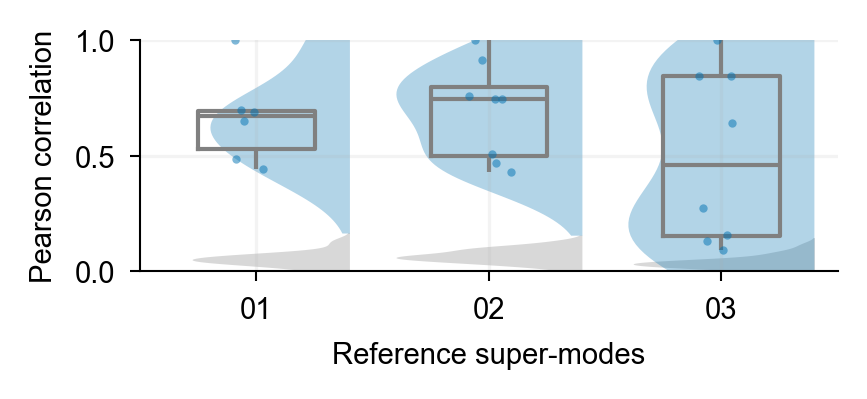

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.0))

sns.violinplot(
    data=1 - null_valid_dists[::20, :], 
    ax=ax, 
    split=True,
    inner=None,
    density_norm='count',
    color='grey',
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)


sns.violinplot(
    data=1 - valid_dists, 
    ax=ax, 
    split=True,
    inner=None,
    density_norm='count',
    color=CUD_COLORS[0],
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)

sns.boxplot(
    data=1 - valid_dists, 
    ax=ax,
    color='grey',
    fill=False, 
    width=0.5, 
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=1 - valid_dists, 
    ax=ax,
    color=CUD_COLORS[0],
    size=2,
    marker='o',
    alpha=0.5, 
    jitter=True,
)

sns.despine(ax=ax)
ymax=1.0
ax.set(
    xlabel='Reference super-modes', 
    xticklabels=[f'{i+1:02d}' for i in range(valid_dists.shape[1])],
    ylabel=f'Pearson correlation',
    ylim=[-0.0, ymax],
)
# for i in range(valid_omegas.shape[-1]):
#     ax.text(i, ymax, f'{recovery_rate[i]:.2f}', ha='center', va='bottom')
ax.grid(alpha=0.15)

In [64]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-distances.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-distances.png', transparent=True, dpi=300, bbox_inches='tight')

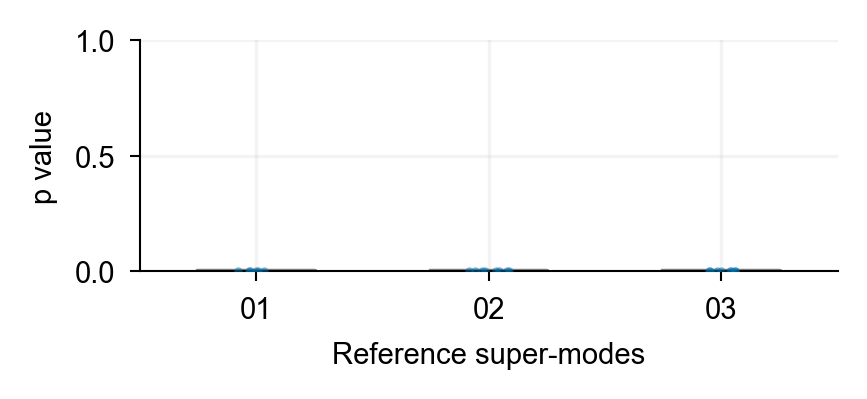

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.0))

sns.violinplot(
    valid_pvalues,
    ax=ax, 
    split=True,
    inner=None, 
    density_norm='count',
    color=CUD_COLORS[0],
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)

sns.boxplot(
    data=valid_pvalues, 
    ax=ax,
    color='grey',
    fill=False, 
    width=0.5, 
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=valid_pvalues, 
    ax=ax,
    color=CUD_COLORS[0],
    size=2,
    marker='o',
    alpha=0.5, 
    jitter=True,
)

sns.despine(ax=ax)
ymax=1.0
ax.set(
    xlabel='Reference super-modes', 
    xticklabels=[f'{i+1:02d}' for i in range(valid_pvalues.shape[1])],
    ylabel=f'p value',
    ylim=[0, ymax],
)
# for i in range(valid_omegas.shape[-1]):
#     ax.text(i, ymax, f'{recovery_rate[i]:.2f}', ha='center', va='bottom')
ax.grid(alpha=0.15)

In [66]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-pvalues.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-pvalues.png', transparent=True, dpi=300, bbox_inches='tight')

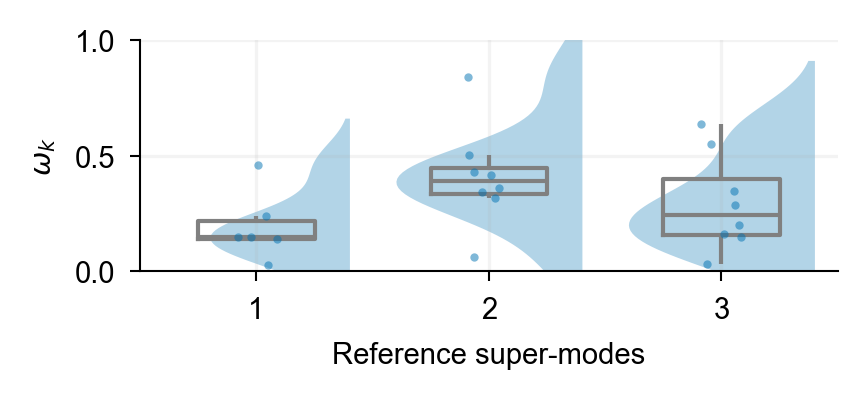

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.0))

sns.violinplot(
    data=valid_omegas,
    ax=ax,
    split=True,
    inner=None, 
    density_norm='count',
    color=CUD_COLORS[0],
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)

sns.boxplot(
    data=valid_omegas, 
    ax=ax,
    color='grey',
    fill=False, 
    width=0.5, 
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=valid_omegas, 
    ax=ax,
    color=CUD_COLORS[0],
    size=2,
    marker='o',
    alpha=0.5, 
    jitter=True,
)

# sns.stripplot(
#     data=valid_omegas[-1, :][None, :], 
#     ax=ax,
#     color=CUD_COLORS[1],
#     size=3, 
#     marker='o',
#     alpha=0.5,
#     jitter=False
# )

ax.grid(alpha=0.15)
sns.despine(ax=ax)
ymax = 1.0
_ = ax.set(xlabel='Reference super-modes', ylabel=r'$\omega_k$', ylim=[0.0, ymax], xticklabels=range(1, 13))
# for i in range(valid_omegas.shape[-1]):
#     ax.text(i, ymax, f'{recovery_rate[i]:.2f}', ha='center', va='bottom')

In [68]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-omegas.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-omegas.png', transparent=True, dpi=300, bbox_inches='tight')

---

In [69]:
valid_omegas_ = valid_omegas.copy()
valid_omegas_[np.isnan(valid_omegas_)] = 0.0
np.round(valid_omegas_, decimals=3)

array([[0.459, 0.341, 0.2  ],
       [0.149, 0.316, 0.032],
       [0.   , 0.839, 0.161],
       [0.148, 0.502, 0.349],
       [0.238, 0.063, 0.286],
       [0.   , 0.362, 0.638],
       [0.139, 0.43 , 0.15 ],
       [0.028, 0.418, 0.553]])

In [70]:
samples = [valid_omegas_[:, i] for i in range(valid_omegas_.shape[-1])]

In [71]:
stat_f, p_f = stats.friedmanchisquare(*samples)
stat_f, p_f

(np.float64(3.25), np.float64(0.19691167520419406))

In [72]:
stat_k, p_k = stats.kruskal(*samples, nan_policy='omit')
stat_k, p_k

(np.float64(7.088081774684653), np.float64(0.028896324053270712))

In [73]:
test_mat = np.zeros((valid_omegas_.shape[1], valid_omegas_.shape[1]))
for (i, j) in combinations(range(valid_omegas_.shape[1]), 2):
    _, p = wilcoxon(
        valid_omegas_[:, i],
        valid_omegas_[:, j], 
        alternative='two-sided', 
        nan_policy='omit',
    )
    test_mat[i, j] = p
    test_mat[j, i] = test_mat[i, j]

[Text(0.5, -20.166666666666675, 'Reference super-modes'),
 Text(30.83333333333339, 0.5, 'Reference super-modes'),
 Text(0.5, 1.0, 'Paired test, p value')]

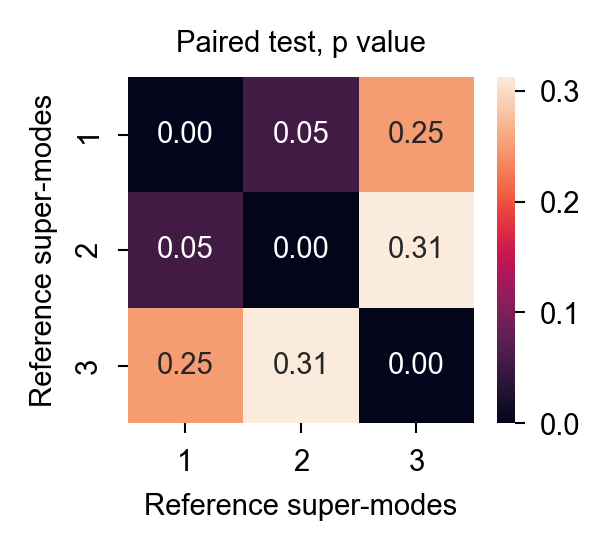

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
sns.heatmap(
    test_mat, 
    ax=ax, 
    square=True,
    annot=True,
    fmt='.2f',
)
ax.set(xticklabels=range(1, test_mat.shape[1]+1), yticklabels=range(1, test_mat.shape[0]+1))
ax.set(xlabel='Reference super-modes', ylabel='Reference super-modes', title=f'Paired test, p value')

In [75]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-super-modes-paired-testing-omega.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-super-modes-paired-testing-omega.png', transparent=True, dpi=300, bbox_inches='tight')

we did detect a clear ranking/hierarchy among any pair of super-modes. i.e. $\omega_k$ of no mode was strictly greater than the other in majority of the resamples.

In [76]:
test_mat = np.zeros((valid_omegas.shape[1], valid_omegas.shape[1]))
for (i, j) in combinations(range(valid_omegas.shape[1]), 2):
    x = valid_omegas[:, i]
    y = valid_omegas[:, j]
    p = (x > y).mean()
    test_mat[i, j] = p
    test_mat[j, i] = test_mat[i, j]

<Axes: >

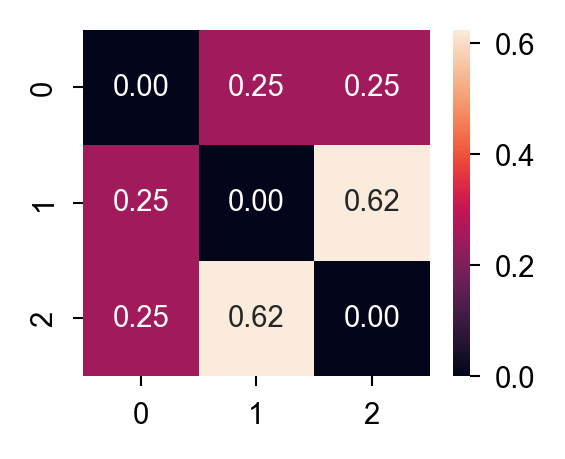

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
sns.heatmap(
    test_mat, 
    ax=ax, 
    square=True,
    annot=True,
    fmt='.2f',
)

---

In [78]:
group = merged_pis_df[merged_pis_df['sub'].isin(['sub-SLC01_task-rest'])].reset_index(drop=True)
group['pi_full'] = group['pi'].apply(lambda pi: pi + mean_pi)
group

sub       sbm    omega  \
0  sub-SLC01_task-rest  sbm-nd-h  0.45896   
1  sub-SLC01_task-rest  sbm-nd-h  0.34132   
2  sub-SLC01_task-rest  sbm-nd-h  0.19972   

                                                  pi  \
0  [[-0.6203013659536094, 0.5780991368661561, 0.0...   
1  [[0.32353061144695866, -0.12451502028197585, -...   
2  [[0.3422913036433003, -0.12451502028197585, -0...   

                                                 sil  \
0     k                       labels     score
0 ...   
1     k                       labels     score
0 ...   
2     k                       labels     score
0 ...   

                                             pi_full  
0  [[0.010824885344529966, 0.7026141571481319, 0....  
1  [[0.954656862745098, 0.0, 0.009803921568627444...  
2  [[0.9734175549414397, 0.0, 0.02658244505856033...

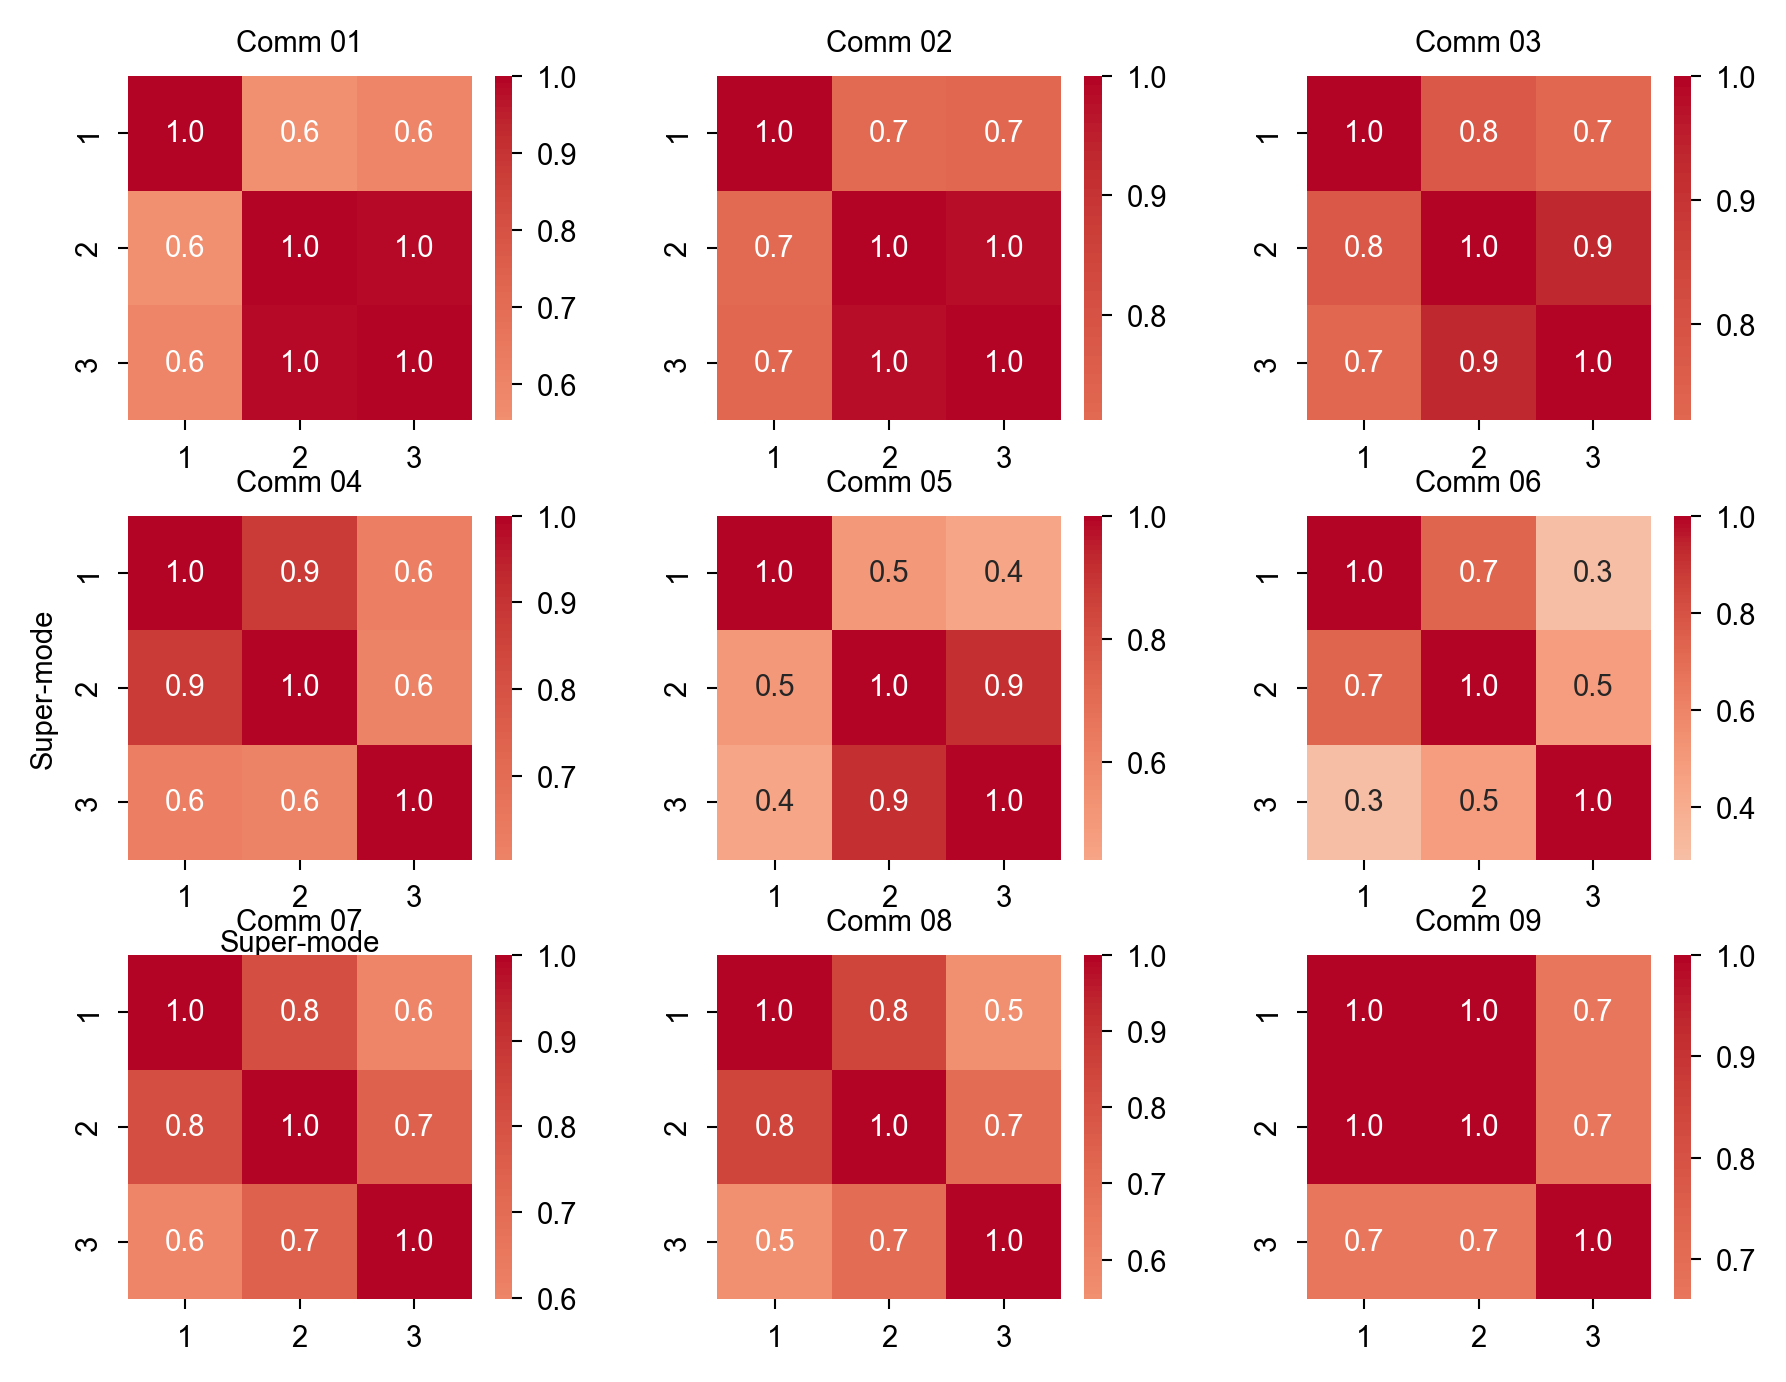

In [79]:
pis = np.stack(group['pi_full'].to_list())
corrs = np.zeros((pis.shape[-1], pis.shape[0], pis.shape[0]))
for idx_comm in range(pis.shape[-1]):
    X = pis[:, :, idx_comm]
    corrs[idx_comm, :, :] = 1 - cdist(X, X, metric='correlation')

ncols = 3
nrows = np.ceil(corrs.shape[0] / ncols).astype('int')
fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 1.5*nrows))
fig.tight_layout()
for idx_comm in range(corrs.shape[0]):
    r, c = idx_comm // ncols, idx_comm % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    
    sns.heatmap(
        corrs[idx_comm, :, :], 
        ax=ax, 
        cmap='coolwarm', center=0, 
        square=True,
        annot=True, fmt='.1f',
    )
    ax.set(
        title=f'Comm {idx_comm+1:02d}',
        xlabel=f'Super-mode' if (r == 1) & (c == 0) else '',
        ylabel=f'Super-mode' if (r == 1) & (c == 0) else '',
        xticklabels=[f'{i+1}' for i in range(corrs.shape[-1])],
        yticklabels=[f'{i+1}' for i in range(corrs.shape[-1])],
    )

In [80]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-comm-correlations.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-comm-correlations.png', transparent=True, dpi=300, bbox_inches='tight')